In [27]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
# from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

def get_Rij(fname):
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats])
    R11 = dat[:,0]
    R12 = dat[:,1]
    R13 = dat[:,2]
    R22 = dat[:,3]
    R23 = dat[:,4]
    R33 = dat[:,5]
    return R11,R12,R13,R22,R23,R33

def get_Mg(directory,flist,thresh=0.1):
    mat = np.zeros([len(flist),3])
    dir_out = directory
    
    for i,fname in enumerate(flist):
        tID = fname.split('_')[-1]
        tID = int(tID.split('.dat')[0])
        time = nml.read_time(directory,tID)

        # Get centerline
        ic,yc = get_centerline(directory,-y,tID)
         
        # Get integral lengthscale
        autocorr = np.fromfile(directory+'lscale_vv_%04d'%(tID)+'.dat',dtype=float,sep=' ')
        autocorr = np.reshape(autocorr,[Ny,3])
        autocorr = autocorr[:,0]
        L_int,tmp,tmp = get_lscale(y,autocorr,thresh=thresh)  
        
        # Get shear S
        utilde = np.fromfile(directory+'shearlayer_utilde_%04d'%(tID)+'.dat',dtype=float, count=-1, sep=' ')
        offset = 10
        i1 = ic-offset
        i2 = ic+offset
        dy = y[i1]-y[i2]
        S = (utilde[i1]-utilde[i2])/dy  
        
        # Get cbar
        cbar = np.fromfile(directory+'shearlayer_cbar_%04d'%(tID)+'.dat', sep=' ')
        
        # Record for later
        mat[i,0] = time
        mat[i,1] = S*L_int/np.amax(cbar)
        mat[i,2] = S*L_int/np.sqrt(1.4)
        
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]

directory = '/home/kmatsuno/ShearLayerData/production/Mc16/rr1/1024x1448x512/'

inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)
dy = abs(y[0]-y[1])

flist = glob.glob(directory+"*cbar*")
flist.sort()
print([f.split('/')[-1] for f in flist])

# And read growth rates
# tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 1.6
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
['shearlayer_cbar_0001.dat', 'shearlayer_cbar_0002.dat', 'shearlayer_cbar_0003.dat', 'shearlayer_cbar_0004.dat', 'shearlayer_cbar_0005.dat', 'shearlayer_cbar_0006.dat', 'shearlayer_cbar_0007.dat', 'shearlayer_cbar_0008.dat', 'shearlayer_cbar_0009.dat', 'shearlayer_cbar_0010.dat', 'shearlayer_cbar_0011.dat', 'shearlayer_cbar_0012.dat']


1.6:[0.788130036061,0.0848898867428]
(1.6, 1.0)


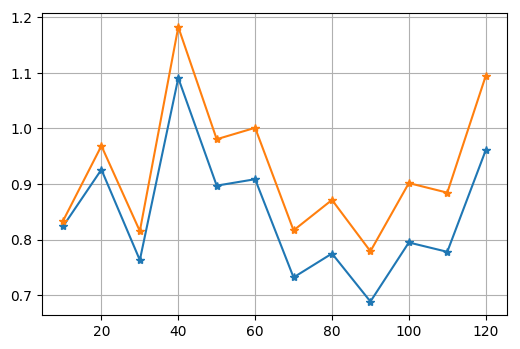

In [14]:
fig = plt.figure(dpi=100)
dat = get_Mg(directory,flist[:])
plt.grid(True)
# plt.xlim([-20,20])
plt.plot(dat[:,0],dat[:,1],'-*')
plt.plot(dat[:,0],dat[:,2],'-*')

idx = 6
ie = None
print('{}:[{},{}]'.format(inp.Mc,np.mean(dat[idx:ie,1]),np.std(dat[idx:ie,1])))
print(inp.Mc,inp.rr)

0.2:[0.293659884152,0.0781811008664],
0.4:[0.442686772573,0.0495245159993],
0.8:[0.565094159096,0.0773577462598],
1.2:[0.64256506778,0.0533216840923],
1.6:[0.816820864085,0.0887838542746],
2.0:[0.848638960457,0.0784194082586],


Text(0.5,0,'$t/\\Delta U$')

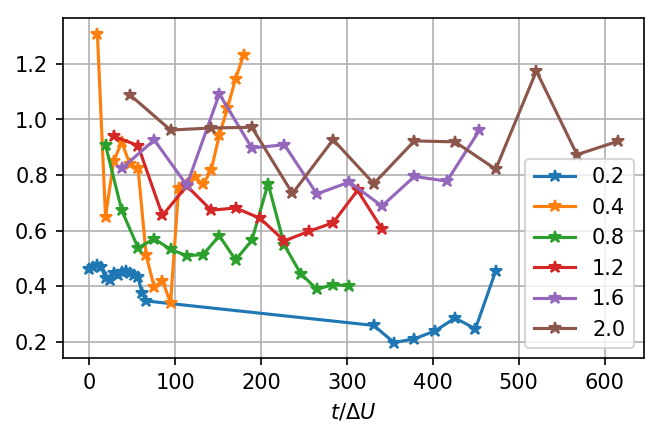

In [26]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(5,3),dpi=150)

for Mc in Mc_list:
    if Mc is '04' or Mc is '02':
        dir_out = '/home/kmatsuno/ShearLayerData/temporal/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    else:
        dir_out = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(dir_out,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(dir_out,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)
    
    flist = glob.glob(dir_out+"*lscale_vv*")
    flist.sort()

    # Plot Rij
    dat = get_Mg(dir_out,flist)
    t = dat[:,0]*inp.du
    f = dat[:,1]
    plt.plot(t,dat[:,1],'-*',label='{}'.format(inp.Mc))
    
#     if Mc=='02': ist=5;ien=10 # mira run
    if Mc=='02': ist=-10;ien=-2 # theta run
    #elif Mc=='04': ist=8;ien=14 #mira run
    elif Mc=='04': ist=6;ien=9 #theta run
    elif Mc=='08': ist=3;ien=-4
    elif Mc=='12': ist=4;ien=None
    elif Mc=='16': ist=4;ien=None
    elif Mc=='20': ist=4;ien=-3
    else: ist=0; ien=None 
    print('{}:[{},{}],'.format(inp.Mc,np.mean(f[ist:ien]),np.std(f[ist:ien])))
    
plt.grid(True)
plt.legend()
plt.xlabel(r'$t/\Delta U$')